In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import calendar

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SVMSMOTE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import optuna

pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',None)

import warnings
warnings.filterwarnings('ignore')

In [24]:
df = pd.read_csv('bank-full.csv',sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [25]:
df.shape

(45211, 17)

## Data Cleaning and Feature Engineering

In [26]:
df['job'] = df['job'].apply(lambda x: x.replace('admin.','admin'))

#BALANCE IS NEGATIVE IN SOME, WHICH IS NOT POSSIBLE
df['balance'] = df['balance'].apply(lambda x: np.abs(x))

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [27]:
# ADDING DAY NAME TO THE DATASET AND TYPE OF DAY (WEEKDAY OR WEEKEND)

months = [x.lower() for x in list(calendar.month_abbr)]
day_name = list(calendar.day_name)

days = []
for idx,row in df.iterrows():
    day_idx = calendar.weekday(2011,months.index(row['month']),row['day'])
    days.append(day_name[day_idx].lower())

df['Day'] = days 

df['Day Type'] = df['Day'].apply(lambda x: 'weekend' if x in ['saturday','sunday'] else 'weekday')

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,Day,Day Type
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,thursday,weekday
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,thursday,weekday
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,thursday,weekday
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,thursday,weekday
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,thursday,weekday


In [28]:
# ADDING AGE BINS AND DURATION BINS

df1 = df.drop(['default','poutcome','loan'],axis = 1)

age_labels = ['0s','10s','20s','30s','40s','50s','60s','70s','80s','90s']
df1['Age bins'] = pd.cut(df1['age'],bins = [0,10,20,30,40,50,60,70,80,90,100],labels=age_labels)

duration_labels = ['0-15','15-30','30-45','45-60','60-75','75-90','90-105']
df1['Duration bins'] = pd.cut(df1['duration'],bins = [0,900,1800,2700,3600,4500,5400,6300],labels=duration_labels)

df1.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,y,Day,Day Type,Age bins,Duration bins
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,no,thursday,weekday,50s,0-15
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,no,thursday,weekday,40s,0-15
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,no,thursday,weekday,30s,0-15
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,no,thursday,weekday,40s,0-15
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,no,thursday,weekday,30s,0-15


In [29]:
# BALANCE IS 0 FOR YES, WHICH CANNOT HAPPEN, HENCE REPLACING IT WITH MEAN

for idx,row in df1[(df1['balance'] == 0) & (df1['y'] == 'yes')].iterrows():
    mean_balance = df1[(df1['job'] == row['job']) & (df1['marital'] == row['marital']) & (df1['education'] == row['education']) & (df1['Age bins'] == row['Age bins']) & (df1['y'] == 'yes')]['balance'].mean()
    if mean_balance!=0:
        df1.at[idx,'balance'] = mean_balance
    else:
        mean_balance_1 = df1[(df1['job'] == row['job']) & (df1['marital'] == row['marital']) & (df1['education'] == row['education']) & (df1['y'] == 'yes')]['balance'].mean()
        if mean_balance_1!=0:
            df1.at[idx,'balance'] = mean_balance_1
        else:
            mean_balance_2 = df1[(df1['job'] == row['job']) & (df1['marital'] == row['marital']) & (df1['y'] == 'yes')]['balance'].mean()
            if mean_balance_2!=0:
                df1.at[idx,'balance'] = mean_balance_2
            else:
                df1.at[idx,'balance'] = df1[df1['y'] == 'yes']['balance'].mean()

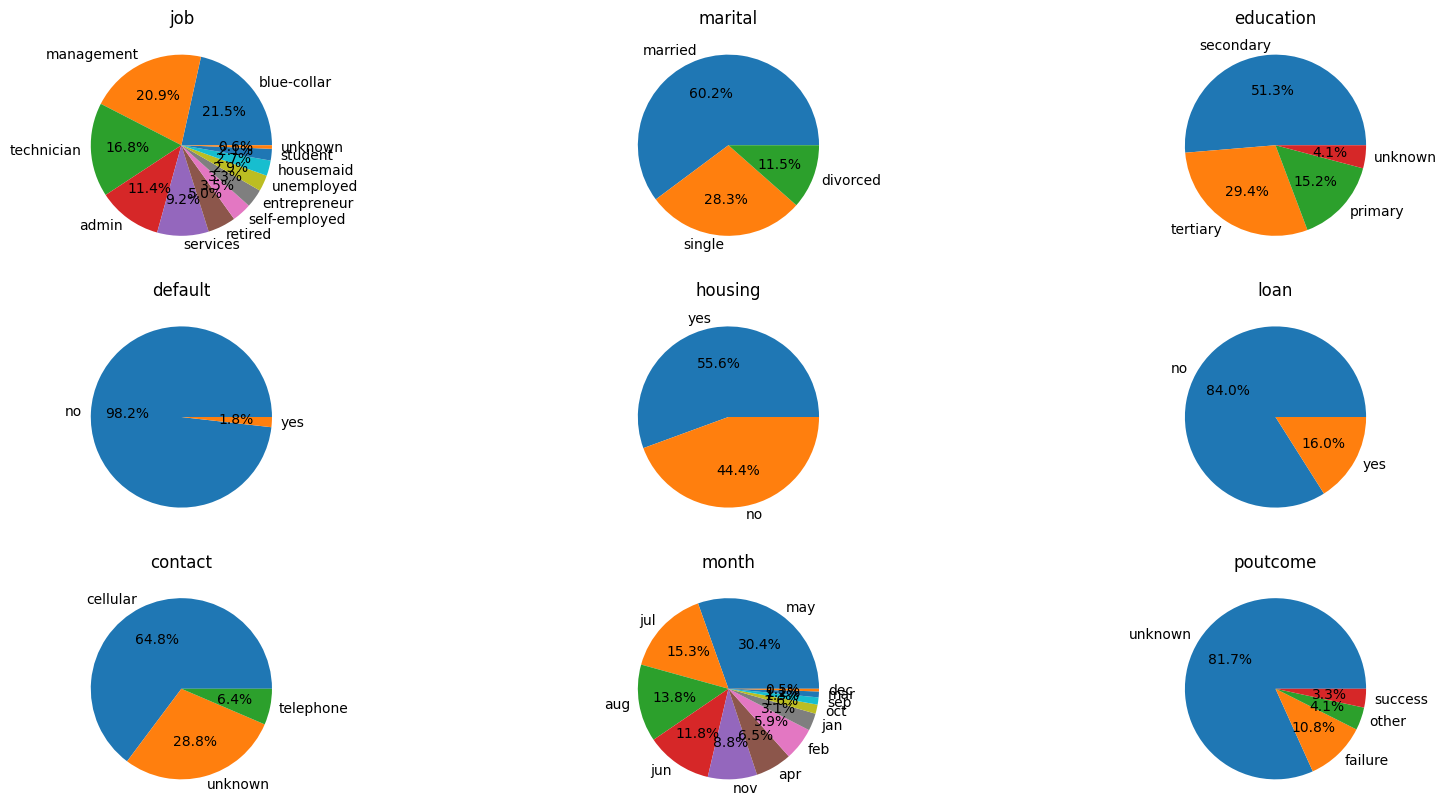

In [30]:
fig,ax = plt.subplots(3,3)
fig.set_figheight(10)
fig.set_figwidth(20)

cols = ['job','marital','education','default','housing','loan','contact','month','poutcome']

tot = -1
for row in range(3):
    for col in range(3):
        tot += 1
        ax[row,col].pie(df[cols[tot]].value_counts(),labels=df[cols[tot]].value_counts().keys(),autopct="%1.1f%%")
        ax[row,col].set_title(cols[tot])

In the above plot, you can see that 81.7 percent of Poutcome column are unknown, and hence I have decided to drop that column. I have also decided to drop Default and Loan column due to low variance

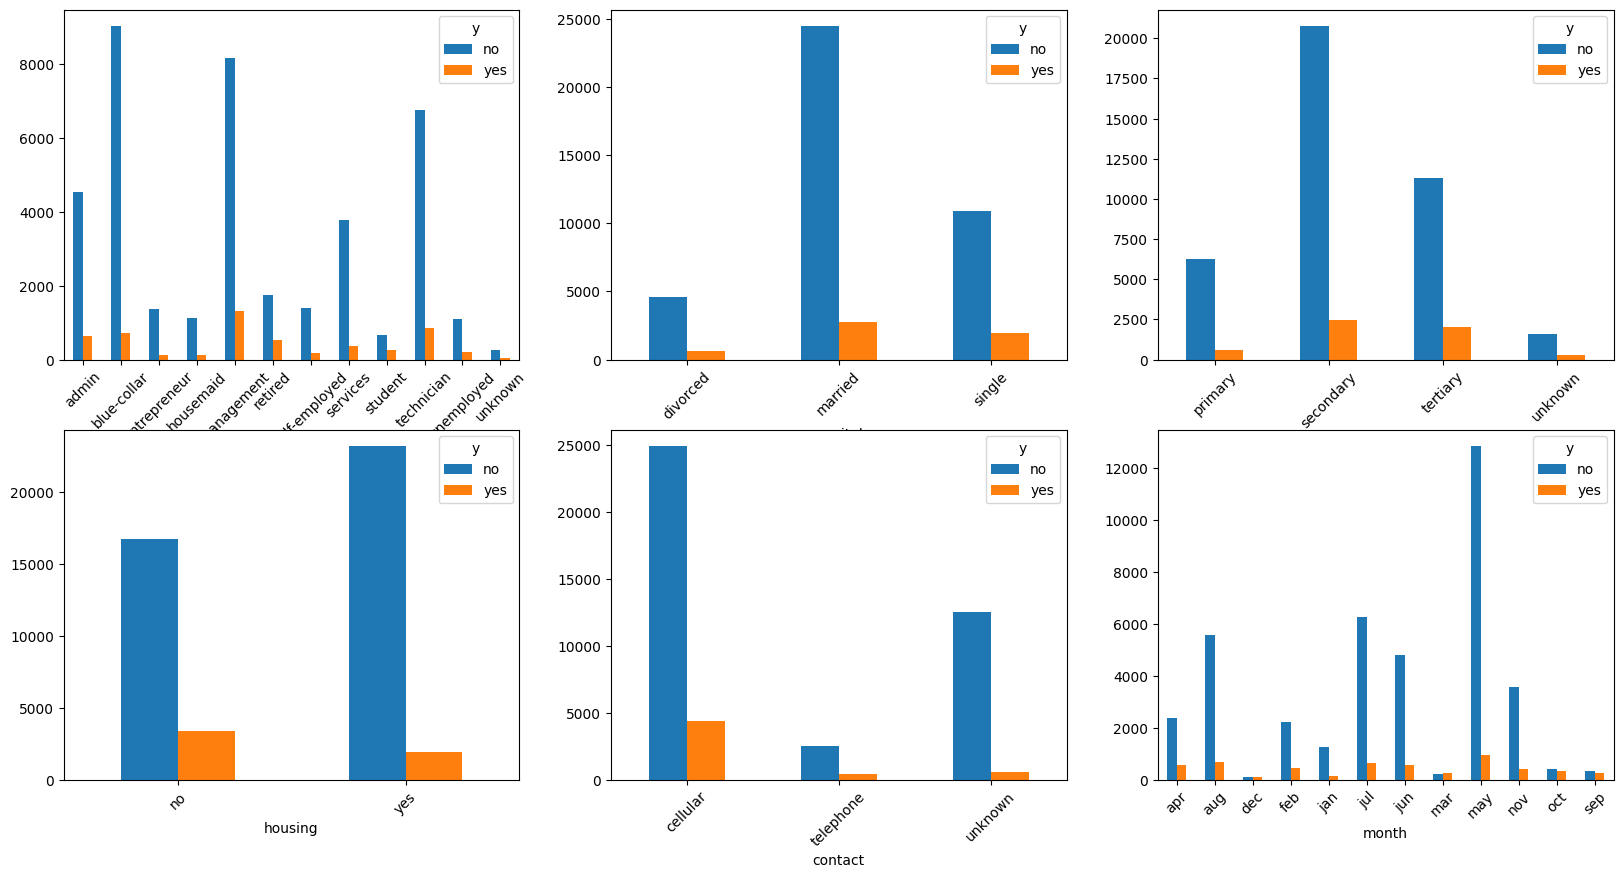

In [31]:
fig,ax = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(20)

cols = ['job','marital','education','housing','contact','month']

tot = -1
for row in range(2):
    for col in range(3):
        tot += 1
        try:
            pd.crosstab(df1[cols[tot]],df1['y']).plot(kind = 'bar',ax = ax[row,col],rot = 45)
        except:
            pass

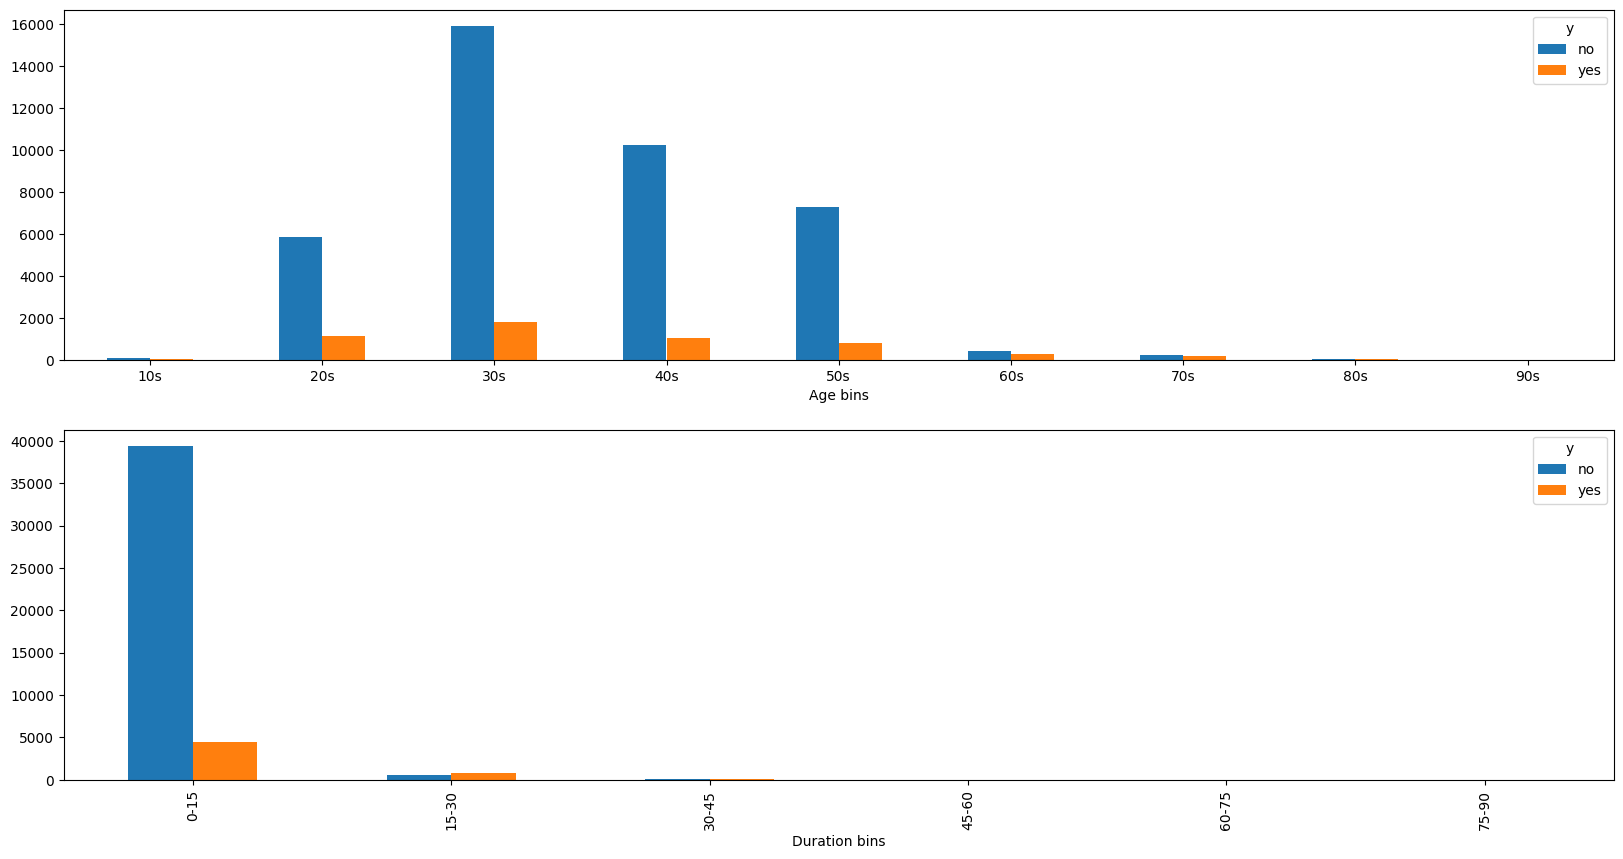

In [32]:
fig,ax = plt.subplots(2,1)
fig.set_figheight(10)
fig.set_figwidth(20)

pd.crosstab(df1['Age bins'],df1['y']).plot(kind = 'bar',ax = ax[0],rot = 0)
pd.crosstab(df1['Duration bins'],df1['y']).plot(kind = 'bar',ax = ax[1],rot = 90)

plt.show()

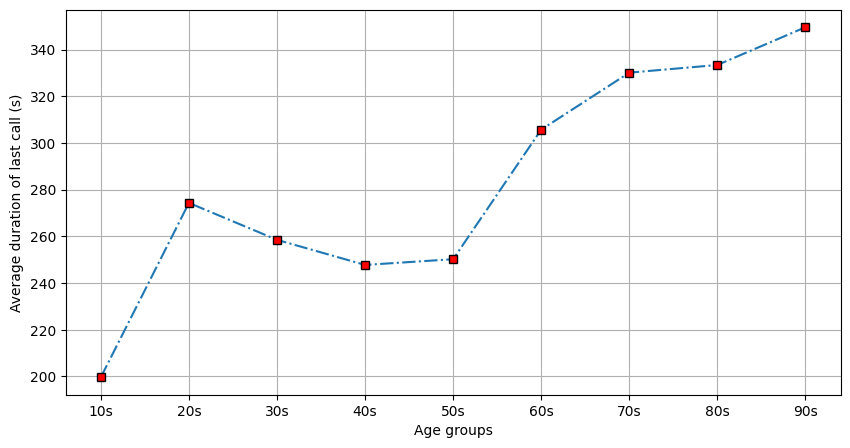

In [33]:
plt.figure(figsize = (10,5))
plt.plot(df1.groupby('Age bins')['duration'].mean()[1:],linestyle = 'dashdot',marker = 's',mfc = 'red',mec = 'black')
plt.xlabel('Age groups')
plt.ylabel('Average duration of last call (s)')
plt.grid()

In [34]:
df1.drop([29182,26227,29989,24148],axis = 0,inplace = True)
df1.reset_index(inplace=True,drop = True)

df1['y'] = df1['y'].apply(lambda x: 1 if x == 'yes' else 0)

df1.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,y,Day,Day Type,Age bins,Duration bins
0,58,management,married,tertiary,2143.0,yes,unknown,5,may,261,1,-1,0,0,thursday,weekday,50s,0-15
1,44,technician,single,secondary,29.0,yes,unknown,5,may,151,1,-1,0,0,thursday,weekday,40s,0-15
2,33,entrepreneur,married,secondary,2.0,yes,unknown,5,may,76,1,-1,0,0,thursday,weekday,30s,0-15
3,47,blue-collar,married,unknown,1506.0,yes,unknown,5,may,92,1,-1,0,0,thursday,weekday,40s,0-15
4,33,unknown,single,unknown,1.0,no,unknown,5,may,198,1,-1,0,0,thursday,weekday,30s,0-15


# Model Creation

In [36]:
df2 = df1.join(pd.get_dummies(df1['job']).astype(int).iloc[:,:-1])

df2 = df2.join(pd.get_dummies(df2['marital']).astype(int).iloc[:,:-1])

df2 = df2.join(pd.get_dummies(df2['education']).astype(int).iloc[:,:-1])

df2 = df2.join(pd.get_dummies(df2['housing']).astype(int).iloc[:,:-1].rename(columns = {'no':'housing_no'}))

df2 = df2.join(pd.get_dummies(df2['contact']).astype(int).iloc[:,:-1])

df2 = df2.join(pd.get_dummies(df2['month']).astype(int).iloc[:,:-1])

df2 = df2.join(pd.get_dummies(df2['Day']).astype(int).iloc[:,:-1])

df2 = df2.join(pd.get_dummies(df2['Day Type']).astype(int).iloc[:,:-1])

df2 = df2.join(pd.get_dummies(df2['Age bins']).astype(int).iloc[:,:-1])

df2.drop(['job','marital','education','housing','contact','month','Day','Day Type','age','Age bins','Duration bins'],axis = 1,inplace = True)
df2.head()

,balance,day,duration,campaign,pdays,previous,y,admin,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,divorced,married,primary,secondary,tertiary,housing_no,cellular,telephone,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,friday,monday,saturday,sunday,thursday,tuesday,weekday,0s,10s,20s,30s,40s,50s,60s,70s,80s
0,2143.0,5,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
1,29.0,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
2,2.0,5,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
3,1506.0,5,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,1.0,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0


In [37]:
X = df2.drop(['y'],axis = 1)
y = df2['y']

In [38]:
X,y = SVMSMOTE().fit_resample(X,y)

In [39]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

# Hyperparameter Tuning

In [41]:
import optuna 

def objective(trial):

    params = {
        'eta': trial.suggest_float('eta',0.01,0.3),
        'max_depth':trial.suggest_int('max_depth',1,300),
        'subsample': trial.suggest_float('subsample',0.1,1),
    }

    model = XGBClassifier(**params)
    model.fit(X_train,y_train)
    return model.score(X_test,y_test)

study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=400)

[I 2024-06-12 00:54:42,258] A new study created in memory with name: no-name-0cf8bb08-2f5e-4860-9e22-b553dd2431b6
[I 2024-06-12 00:54:43,005] Trial 0 finished with value: 0.9509644288577155 and parameters: {'eta': 0.17616572633836322, 'max_depth': 9, 'subsample': 0.7223949758764003}. Best is trial 0 with value: 0.9509644288577155.
[I 2024-06-12 00:54:44,649] Trial 1 finished with value: 0.9509644288577155 and parameters: {'eta': 0.29780355303150324, 'max_depth': 33, 'subsample': 0.5333813884222213}. Best is trial 0 with value: 0.9509644288577155.
[I 2024-06-12 00:54:46,494] Trial 2 finished with value: 0.9517159318637275 and parameters: {'eta': 0.18398887033911493, 'max_depth': 155, 'subsample': 0.6456462390185319}. Best is trial 2 with value: 0.9517159318637275.
[I 2024-06-12 00:54:48,335] Trial 3 finished with value: 0.9519664328657315 and parameters: {'eta': 0.26000272790577195, 'max_depth': 173, 'subsample': 0.7287183878999839}. Best is trial 3 with value: 0.9519664328657315.
[I 20

{'eta': 0.11108831637612655, 'max_depth': 242, 'subsample': 0.845528219985605}
0.9999217135341643
0.9536573146292585


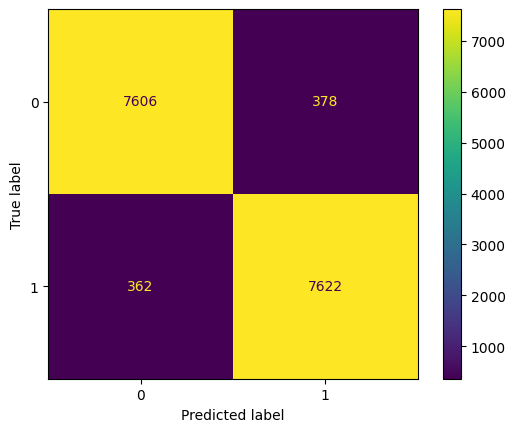

In [43]:
param = study.best_params
print(param)
xgb = XGBClassifier(**param)
xgb.fit(X_train,y_train)
print(xgb.score(X_train,y_train))
print(xgb.score(X_test,y_test))

cm = confusion_matrix(y_test,xgb.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Model Prediction

In [57]:
xgb = XGBClassifier(eta= 0.11108831637612655, max_depth = 242, subsample = 0.845528219985605)
xgb.fit(X_train,y_train)
xgb.score(X_test,y_test)

0.9536573146292585

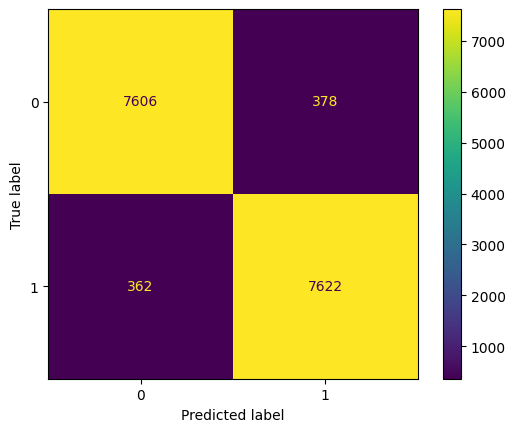

In [58]:
cm = confusion_matrix(y_test,xgb.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [59]:
import pickle
pickle.dump(xgb,open('model.pkl','wb'))